## Project Overview

InstructLab uses a novel synthetic data-based alignment tuning method for Large Language Models (LLMs.) The "**lab**" in Instruct**Lab** stands for **L**arge-Scale **A**lignment for Chat**B**ots.

It is an outgrowth of the paper [*LAB: Large-Scale Alignment for ChatBots*](https://arxiv.org/abs/2403.01081).

### Getting Started

This notebook represents one step in the InstructLab pipeline – to see what else is involved, please check out https://github.com/instructlab/instructlab

## Overview of this Notebook

This notebook represents the *Train the model* step of the guide found [here](https://github.com/instructlab/instructlab?tab=readme-ov-file#-train-the-model).

But at the time of writing it's not.

This notebook takes the output of `ilab data generate` (i.e. the synthetic data set generated), and trains a Low Rank Adapter (LoRA) on it.

It will also do an inference to show you how the model preformed before any training was done, as well as after.

Finally, it will give you a chance to interact with your model in two ways: first in this notebook (using the NVIDIA T4 generously supplied by Google and low/no cost) and second, by giving you the option to convert your adapter to a format that will let you download it and use it with `llama.cpp` on your laptop.

***IMPORTANT***: make sure your notebook uses GPUs.

**Google Collab**: In your notebook, click Runtime --> Change runtime type, and select *T4 GPU* and click save.

**Kaggle (Unsupported and deprecated)**: Click on "More settings" (3 vertical
dots
 at the top-right) --> Accelerator, and select *P100 GPU*.


![kaggle-more-settings](https://github.com/instructlab/instructlab/blob/main/notebooks/images/kaggle/select-accelerator.png?raw=1)
If you miss this step you'll see errors at the Loading model step.


## How to run this notebook

Unless you have a spare GPU with 16GB+ of VRAM,
you'll need to run this notebook on an external platform such as
[Google Collab](https://colab.research.google.com/) if you have serious
issues with Google, there are also some unmaintained directions for using
[Kaggle](https://www.kaggle.com).

## Installing Dependencies

In [ ]:
# 🧹 Step 1: Fix NumPy before anything else
!pip install numpy==1.26.4 --force-reinstall

import os
os._exit(0)  # 🔄 Force Colab to restart the runtime cleanly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# installing dependencies



#!pip install -q -U transformers accelerate peft datasets bitsandbytes trl pyarrow==14.0.1 requests==2.31.0 torch==2.4.0
# 🔧 1. Uninstall the conflicting preinstalled packages
!pip uninstall -y torch torchvision torchaudio

# 🧱 2. Reinstall matching, stable versions that TRL + transformers expect
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121

# 📦 3. Reinstall transformers/trl/etc.
!pip install -q -U transformers accelerate peft datasets bitsandbytes trl pyarrow==14.0.1 requests==2.31.0



Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.4.0%2Bcu121-cp312-cp312-linux_x86_64.whl (799.0 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.19.0%2Bcu121-cp312-cp312-linux_x86_64.whl (7.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.4.0%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Upload output from `ilab data generate`


## Uploading Generated Data
From your local machine, run the `ilab data generate` command per the [instructions in github](https://github.com/instructlab/instructlab/blob/main/README.md).

Next, upload your data.

### Uploading data in Google Collab

To upload data in Google Colab,

1. Click on the folder icon on the left of the screen.

 ![image.png](https://github.com/instructlab/instructlab/blob/main/notebooks/images/collab-folder-icon.png?raw=1)

2. Click on the file with an up arrow in it icon, under it.

 ![image.png](https://github.com/instructlab/instructlab/blob/main/notebooks/images/collab-file-upload-button.png?raw=1)

3. Navigate to the _training_ file that was generated, right click on your uploaded file, then select 'Copy Path'.

 ![image.png](https://github.com/instructlab/instructlab/blob/main/notebooks/images/collab-copy-path.png?raw=1)

4. Paste the copied value for each corresponding variable in the cell below. `training_file_name` for the `train_*` file and `testing_file_name` for `test_*` file
.

### Uploading data on Kaggle (Unsupported and deprecated)

1. Expand on the Input tab on the right of the screen.

![input](https://github.com/instructlab/instructlab/blob/main/notebooks/images/kaggle/input.png?raw=1)


2. Click on the "Upload" button, then select "New Dataset".

Upload button:

![input-upload](https://github.com/instructlab/instructlab/blob/main/notebooks/images/kaggle/input-upload.png?raw=1)

New Dataset:

![input-new-dataset](https://github.com/instructlab/instructlab/blob/main/notebooks/images/kaggle/new-dataset.png?raw=1)

3. From here, you'll be prompted to upload your local files. Go ahead and select all of the files generated from lab generate. These files will be in the ./taxonomy directory and begin with "test", and "train".
Note: If using Kaggle you will need to remove the colons from the file name or it will present an error on upload. Here is an example of how to remove them:

```bash
newname=`ls taxonomy/ | grep -i train | awk -F: '{print $1$2$3}'`; mv taxonomy/train*.jsonl taxonomy/${newname}

newname2=`ls taxonomy/ | grep -i test | awk -F: '{print $1$2$3}'`; mv taxonomy/test*.jsonl taxonomy/${newname2}
```

![upload-file](https://github.com/instructlab/instructlab/blob/main/notebooks/images/kaggle/input-drop-files.png?raw=1)

4. Navigate to the _training_ file that was generated (it will be in the taxonomy directory on your local machine and end in .jsonl), right click on your uploaded file, then select 'Copy Path'

![input-files-copy-path](https://github.com/instructlab/instructlab/blob/main/notebooks/images/kaggle/copy-file-path.png?raw=1)

5. Paste the copied value in the cell below.


#### Upload Training Data

In [2]:
from datasets import load_dataset

# Get the file name
training_file_name = "/content/Train Data Sept 24 2025.jsonl"  # "/paste/path/here"

train_dataset = load_dataset("json", data_files=training_file_name, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

#### Upload Testing Data

In [3]:
# Get the file name
testing_file_name = "/content/Test Sept 24 2025.jsonl"  # "/paste/path/here"

test_dataset = load_dataset("json", data_files=testing_file_name, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Now we have loaded the output of `ilab data generate` into a 🤗 dataset. Let's take a quick peek.

In [ ]:
train_dataset.to_pandas().head()

,system,user,assistant
0,I am an advanced AI language model designed to...,What is RISC-V assembly language?,RISC-V assembly language is a low-level progra...
1,I am an advanced AI language model designed to...,Why use RISC-V assembly language?,It provides low-level access and control over ...
2,I am an advanced AI language model designed to...,What role does RISC-V assembly language play i...,RISC-V assembly language is a low-level progra...
3,I am an advanced AI language model designed to...,Why is RISC-V assembly language closely tied t...,GNU Assembler and LLVM are commonly used assem...
4,I am an advanced AI language model designed to...,How does the use of RISC-V assembly language c...,RISC-V assembly language's close relationship ...


## Formatting Our Data and Prepping the `SFTTrainer`

Our dataset looks good, but in it's current state, it is a data frme of three columns. For training, we need each record to be a string, specifically, we want it in the following format:

```
<|system|>
{system}
<|user|>
{user}
<|assistant|>
{assistant}<|endoftext|>
```


When training happens (a few cells later), the dataset will be converted into a list of these strings. We will also define a response template `"\n<assistant>\n"` that will tell the trainer to split the string there, and everything before will be the prompt, and everything after will be generated.

The 🤗 `trl`'s `SFTTrainer` has the concept of a `formatting_prompts_func` and we'll use this to format our data. The conversion does not happen now, but later when we run `trainer.train()`

From more information on 🤗's `SFTTrainer`, please check out their docs [here](https://huggingface.co/docs/trl/main/en/sft_trainer).


In [6]:
from transformers import AutoTokenizer
from trl import DataCollatorForCompletionOnlyLM

model_name = "instructlab/merlinite-7b-lab"  # TODO: Make this a drop down option
#model_name = "instructlab/mistral-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["system"])):
        text = f"<|system|>\n{example['system'][i]}\n<|user|>\n{example['user'][i]}\n<|assistant|>\n{example['assistant'][i]}<|endoftext|>"
        output_texts.append(text)
    return output_texts


response_template = "\n<|assistant|>\n"

response_template_ids = tokenizer.encode(response_template, add_special_tokens=False)[
    2:
]
collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

In the cell above, you may see a user warning:
> `The secret `HF_TOKEN` does not exist in your Colab secrets...`

It can safely be ignored.

Note: the `formatting_prompts_func` runs when we execute `trainer.train()`. Nothing has been formatted yet.

## Loading the (Quantized) Model


The best source of truth of this is going to be found at the following links:

* [huggingface blog post](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
* [original paper](https://arxiv.org/abs/2305.14314)

But alas, I'm sure to get some push back about `Llama.cpp` quantized models (things that end in .gguf).

`bitsandbytes` will quantize the model on loading. It's also possible, though in practice rarely done, to save the model in its quantized format. Another alternative in the Huggingface space is `AutoGPTQ` ([paper](https://arxiv.org/abs/2210.17323) [blog post](https://huggingface.co/blog/gptq-integration)).

`Llama.cpp` also allows quantization, but the idea is that you _will_ be using the CPU because you know the model at hand is too big for your GPU.

An analogy that isn't wildly inaccurate is `bitsandbytes` and `AutoGPTQ` presume that you will be using a (CUDA-based) GPU, and that you can set it in an emergency to use CPU instead of just rolling over and dying.

`Llama.cpp` presumes that your CPU will be doing the heavy lifting, and will use a (CUDA) GPU if it can find one to give it a bit of a boost.

OK, what does that mean in practice?
1. Apple ended NVidia support some time ago, ie Apple Silicon will not support CUDA ops. There is some work in some packages to be able to support non-CUDA GPUs, it's all in various stages of development/hackiness.
2. [This person](https://rentry.org/cpu-lora) _did_ get qLoRA training with Llama.cpp working. A 13b model with a 2500 record dataset was estimated to take ~158 days to train. Which is a non-starter- I will trust they did their homework.
3. **High level** Llama.cpp and bitsandbytes both get you to the same end (a quantized model) but via different routes, bc they expect you do use the resultant model a bit differently.
4. **So do I need to quantize my model via both routes** no.

In the next cell we're going to download and load the model.

It may take a little time to complete (around 10 to 15 minutes). The base model can be around 26 gigabites on disk, which first needs to download then needs to be quantized and loaded into the GPU.

So run this cell then go grab a cup of coffee. ☕

In [7]:
# Loading the model
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,  # if not set will throw a warning about slow speeds when training
)

model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=bnb_config, trust_remote_code=True
)

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

## Sanity Checking the Model

We want to see how the model behaves _before_ we train a LoRA on it, so we can (by inspection) see if the LoRA is doing anything.

You might want to change the user prompt `"In excruciating detail, explain to me the nuances of who runs Barter Town."` to something more related to _your_ usecase.

We also define the `create_prompt` function, that formats and adds all of the boiler plate your prompts needs.

Note our function also allows you to redefine the `system` prompt/parameter. The default is the one included in `ilab data generate` content, but you could have some fun tinkering with that too (for instance, adding `, and you always talk like a pirate.` to the end.)

In [8]:
from transformers import StoppingCriteria, StoppingCriteriaList


def create_prompt(
    user: str,
    system: str = "You are an AI language model developed by IBM Research. You are a cautious assistant. You carefully follow instructions. You are helpful and harmless and you follow ethical guidelines and promote positive behavior.",
):
    return f"""\
<|system|>
{system}
<|user|>
{user}
<|assistant|>
"""


class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops=(), encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(
        self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs
    ) -> bool:
        for seq in input_ids:
            for stop in self.stops:
                if stop == seq[-1]:
                    return True
        return False


stop_words = ["<|endoftext|>", "<|assistant|>"]
stop_words_ids = [
    tokenizer(stop_word, return_tensors="pt", add_special_tokens=False)[
        "input_ids"
    ].squeeze()
    for stop_word in stop_words
]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])


def model_generate(user):
    text = create_prompt(user=user)

    input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(
        input_ids=input_ids,
        max_new_tokens=256,
        pad_token_id=tokenizer.eos_token_id,
        temperature=0.7,
        top_p=0.9,
        stopping_criteria=stopping_criteria,
        do_sample=True,
    )
    return tokenizer.batch_decode([o[:-1] for o in outputs])[0]


print(
    model_generate(
        "In excruciating detail, explain to me the nuances of RISC-V Assembly"
    )
)

<|system|> 
You are an AI language model developed by IBM Research. You are a cautious assistant. You carefully follow instructions. You are helpful and harmless and you follow ethical guidelines and promote positive behavior.
<|user|> 
In excruciating detail, explain to me the nuances of RISC-V Assembly
<|assistant|> 
RISC-V Assembly is a low-level programming language used to write programs that run directly on RISC-V processors. It is a highly efficient and flexible language, but it can be complex due to its low-level nature. Here's an overview of some of its nuances:

1. **Instructions and operations**: RISC-V Assembly consists of a set of instructions that perform specific operations. These instructions can be broken down into categories such as data processing, control flow, and memory management.

2. **Registers**: RISC-V processors use a set of registers to store temporary data. These registers include general-purpose registers (x0-x31), floating-point registers (f0-f31), and s

we run the model before LoRA on the test set and save the outputs

In [ ]:
assistant_old_lst = [
    model_generate(d["user"]).split(response_template.strip())[-1].strip()
    for d in test_dataset
]

In [ ]:
def model_generate(user):
    text = create_prompt(user=user)

    input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(
        input_ids=input_ids,
        max_new_tokens=256,
        pad_token_id=tokenizer.eos_token_id,
        temperature=0.7,
        top_p=0.9,
        stopping_criteria=stopping_criteria,
        do_sample=True,
    )
    return tokenizer.batch_decode([o[:-1] for o in outputs])[0]

def create_prompt(
    user: str,
    system: str = "You are an AI language model developed by IBM Research. You are a cautious assistant. You carefully follow instructions. You are helpful and harmless and you follow ethical guidelines and promote positive behavior.",
):
    return f"""\
<|system|>
{system}
<|user|>
{user}
<|assistant|>
"""

## Configuring the LoRA

Recall the [paper on LoRA](https://arxiv.org/abs/2106.09685):

> From this point forth, we shall be leaving the firm foundation of fact and journeying together through the murky marshes of memory into thickets of wildest guesswork.
-- Albus Dumbledore

There are 4 common 'knobs' to adjust when training a LoRA/qLoRA - note from this point on, I'm just going to refer to everything as LoRA- a LoRA proved a better method of finetuning, by just targeting certain modules, instead of the entire network. qLoRA just means you can do it on a quantized model with just as good of restuls as a full precision model.

Which is a good segway to our first 'knob': `target_modules`.




### Getting the Attention Layers

The cell immediately below will print out all of the attention modules (in case you are trying to get creative and use a different model). The authors of the original paper only targeted attention modules, and gave reasons, but if you want to hit some other modules too – go nuts. Be advised, a LoRA that targets _all_ modules is just fine-tuning: the LoRA technique is to only tune a subset of the modules.

For `instructlab/merlinite-7b-lab` we have:
```
target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj"
    ]
```


In [ ]:
attention_layers = [
    module for module in model.modules() if "attention" in str(type(module)).lower()
]

# Print information about the attention modules
for layer in attention_layers:
    for par in list(layer.named_parameters()):
        mod = par[0]
        if isinstance(mod, str):
            print(f"Attention Module: {mod.split('.')[0]}")
    break

### Turning the Knobs

The next three knobs are:
- r
- dropout
- &alpha;

Read the paper for more information on each- these three parameters have been the source of endless flame wars across the internet- feel free to google and see the carnage for yourself.

I picked the following based on what the authors used for GPT2 in the paper (see page 20)

```
lora_alpha = 32
lora_dropout = 0.1
lora_r = 4
```

Not probably what I would have used, but I am not trying to spread the flame wars, so there you are. In reality, these are the knobs end users will be tinkering with. We _could_ come up with a suggested range, but the 'correct' values are highly dependent on the task and even the underlying dataset, so I wouldn't waste too much effort trying.

Once I read a quote on a message board that described the situation perfectly, then I couldn't find it so I asked ChatGPT which hallucinated it pretty well:

> Every chef has their own secret recipe for success, but in the kitchen of life, there's no right or wrong way to cook up your dreams.
-- ChatGPT

In [11]:
from peft import LoraConfig

lora_alpha = 32
lora_dropout = 0.1
lora_r = 4

# From Prior Cell
target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"]

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules,
)

## Training the LoRA

### Training Config

As always, it is out of scope for me to explain all of these, especially when it has already been done so well [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

That said I will call out two values I set, and why I set them.

- `max_seq_length`
- `per_device_train_batch_size`

Both of these parameters were set in an attempt to get as much use as possible out of the NViDIA T4.

`max_seq_length` will trim any example to `300` tokens. So even if your examples are longer, they will be truncated. (Also recall that the system prompt also counts against your 300 tokens).

`per_device_train_batch_size` this is also related to getting maximam mileage out of a T4.

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 1


training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=per_device_train_batch_size,
    fp16=True,
    report_to="none",
)

In the following cell- the trainer is built, and the dataset is formatted. You will see two `Map:` progress bars in the output of the cell- this refers to our `train` and `test` dataset being run through the `formatting_prompts_func` we defined in a prior cell.

Also note: `model.config.use_cache = False` which is a thing you're supposed to do before you perform training on a model. Remember to turn it back on (to `true`) before running inference.

In [ ]:
from trl import SFTTrainer

max_seq_length = 300
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

model.config.use_cache = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


### Execute Training

The next cell calls `trainer.train()`, which actually executes the training. This will take 5 to 15 minutes, depending on how big your dataset is.

In [12]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 1

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=1,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",
    logging_steps=10,
    logging_dir="./logs",
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

"""## Build Trainer"""

from trl import SFTTrainer

max_seq_length = 300
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

model.config.use_cache = False

"""## Execute Training"""

# trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


'## Execute Training'


MODEL EVALUATION

1. Computing evaluation loss and perplexity...


   ✓ Evaluation Loss: 2.0875
   ✓ Perplexity: 8.07 (lower is better)

2. Computing token-level metrics on 50 examples...
   Progress: 10/50
   Progress: 20/50
   Progress: 30/50
   Progress: 40/50
   Progress: 50/50
   ✓ Completed evaluation on 50 examples

EVALUATION SUMMARY

📊 Test Set Performance (n=50)

🔹 Loss & Perplexity (full test set)
   Evaluation Loss: 2.0875
   Perplexity:      8.07

🔹 Token-Level Metrics
   Precision: 0.1392 ± 0.1725
   Recall:    0.7353 ± 0.2042
   F1 Score:  0.1863 ± 0.1444

🔹 Exact Match
   Rate: 0.00%

🔹 Response Length (in tokens)
   Expected:  11.5 ± 2.5
   Generated: 200.7 ± 88.1
   Difference: +189.2 tokens


SAMPLE OUTPUTS

EXAMPLE 1

👤 USER:
What is RISC-V?
RISC-V is an open standard instruction set architecture.

✅ EXPECTED:
RISC-V is an open standard instruction set architecture.

🤖 GENERATED:
RISC-V is an instruction set architecture (ISA) that was developed as an open standard by the RISC-V Foundation, a non-profit organization. It is a reduce

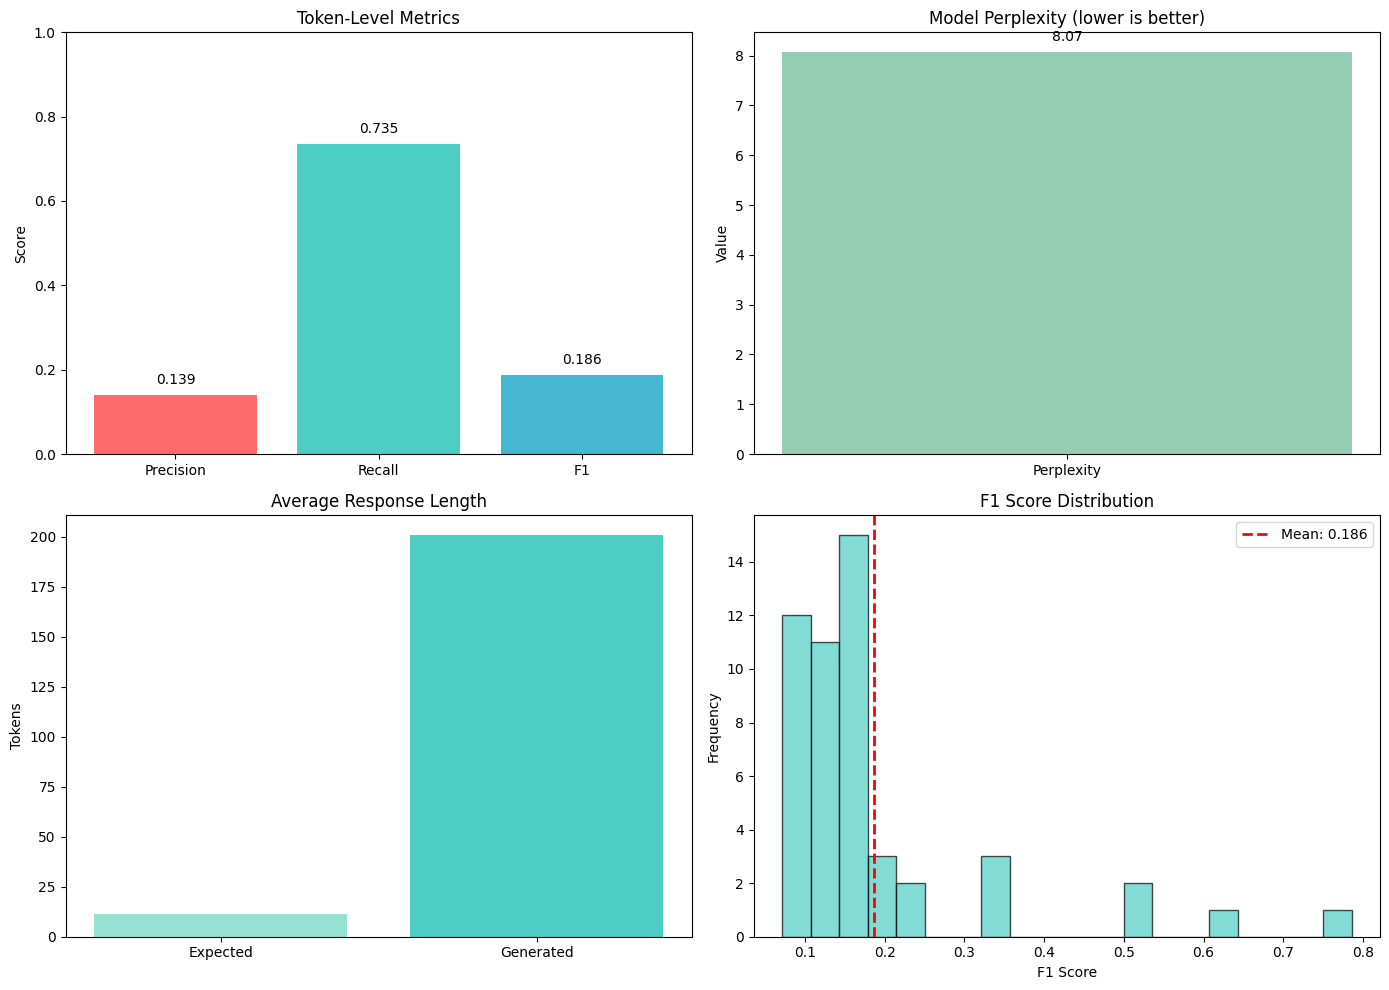


Saving results...
✓ Metrics saved to './results/evaluation_metrics.csv'
✓ Report saved to './results/evaluation_report.txt'

EVALUATION COMPLETE!


In [13]:
"""
Standalone Evaluation Script for LoRA Models
Computes: Perplexity, F1, Precision, Recall, Exact Match
"""

import torch
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# ============================================================================
# CONFIGURATION
# ============================================================================
sample_size = 50  # Number of test examples to evaluate (for speed)
response_template = "\n<|assistant|>\n"

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def compute_token_metrics(pred_tokens, true_tokens):
    """Compute token-level precision, recall, F1"""
    pred_set = set(pred_tokens)
    true_set = set(true_tokens)

    if len(pred_set) == 0 or len(true_set) == 0:
        return 0.0, 0.0, 0.0

    tp = len(pred_set & true_set)

    precision = tp / len(pred_set) if len(pred_set) > 0 else 0
    recall = tp / len(true_set) if len(true_set) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


def extract_assistant_response(full_output, response_template):
    """Extract just the assistant's response from full model output"""
    return full_output.split(response_template.strip())[-1].strip()


# ============================================================================
# MAIN EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# 1. Compute evaluation loss and perplexity using trainer
print("\n1. Computing evaluation loss and perplexity...")
eval_results = trainer.evaluate()

eval_loss = eval_results['eval_loss']
eval_perplexity = np.exp(eval_loss)

print(f"   ✓ Evaluation Loss: {eval_loss:.4f}")
print(f"   ✓ Perplexity: {eval_perplexity:.2f} (lower is better)")

# 2. Token-level metrics on sample
print(f"\n2. Computing token-level metrics on {sample_size} examples...")

# Ensure cache is enabled for generation
model.config.use_cache = True

# Initialize metrics storage
metrics = {
    'token_precision': [],
    'token_recall': [],
    'token_f1': [],
    'exact_match': [],
    'expected_length': [],
    'generated_length': []
}

# Evaluate on subset
eval_sample_size = min(len(test_dataset), sample_size)
for i, d in enumerate(test_dataset.select(range(eval_sample_size))):
    if (i + 1) % 10 == 0:
        print(f"   Progress: {i+1}/{eval_sample_size}")

    # Generate response
    full_output = model_generate(d["user"])
    assistant_generated = extract_assistant_response(full_output, response_template)
    assistant_expected = d["assistant"]

    # Tokenize for comparison
    gen_tokens = tokenizer.tokenize(assistant_generated.lower())
    exp_tokens = tokenizer.tokenize(assistant_expected.lower())

    # Compute token metrics
    precision, recall, f1 = compute_token_metrics(gen_tokens, exp_tokens)

    metrics['token_precision'].append(precision)
    metrics['token_recall'].append(recall)
    metrics['token_f1'].append(f1)
    metrics['exact_match'].append(1 if assistant_generated.strip() == assistant_expected.strip() else 0)
    metrics['expected_length'].append(len(exp_tokens))
    metrics['generated_length'].append(len(gen_tokens))

# Create DataFrame
df_metrics = pd.DataFrame(metrics)

print(f"   ✓ Completed evaluation on {eval_sample_size} examples")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("EVALUATION SUMMARY")
print("="*80)

print(f"\n📊 Test Set Performance (n={eval_sample_size})")
print(f"{'='*80}")

print("\n🔹 Loss & Perplexity (full test set)")
print(f"   Evaluation Loss: {eval_loss:.4f}")
print(f"   Perplexity:      {eval_perplexity:.2f}")

print("\n🔹 Token-Level Metrics")
print(f"   Precision: {df_metrics['token_precision'].mean():.4f} ± {df_metrics['token_precision'].std():.4f}")
print(f"   Recall:    {df_metrics['token_recall'].mean():.4f} ± {df_metrics['token_recall'].std():.4f}")
print(f"   F1 Score:  {df_metrics['token_f1'].mean():.4f} ± {df_metrics['token_f1'].std():.4f}")

print("\n🔹 Exact Match")
print(f"   Rate: {df_metrics['exact_match'].mean()*100:.2f}%")

print("\n🔹 Response Length (in tokens)")
print(f"   Expected:  {df_metrics['expected_length'].mean():.1f} ± {df_metrics['expected_length'].std():.1f}")
print(f"   Generated: {df_metrics['generated_length'].mean():.1f} ± {df_metrics['generated_length'].std():.1f}")
length_diff = df_metrics['generated_length'].mean() - df_metrics['expected_length'].mean()
print(f"   Difference: {length_diff:+.1f} tokens")

print("\n" + "="*80)

# ============================================================================
# SAMPLE OUTPUTS
# ============================================================================

print("\n" + "="*80)
print("SAMPLE OUTPUTS")
print("="*80)

num_examples = min(3, eval_sample_size)
for i in range(num_examples):
    example = test_dataset[i]
    full_output = model_generate(example["user"])
    generated = extract_assistant_response(full_output, response_template)

    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}")
    print(f"{'='*80}")
    print(f"\n👤 USER:")
    print(example["user"])
    print(f"\n✅ EXPECTED:")
    print(example["assistant"])
    print(f"\n🤖 GENERATED:")
    print(generated)
    print(f"\n📊 METRICS:")
    print(f"   Token F1:        {df_metrics.iloc[i]['token_f1']:.3f}")
    print(f"   Token Precision: {df_metrics.iloc[i]['token_precision']:.3f}")
    print(f"   Token Recall:    {df_metrics.iloc[i]['token_recall']:.3f}")
    print(f"   Exact Match:     {'✓' if df_metrics.iloc[i]['exact_match'] == 1 else '✗'}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("Generating visualizations...")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Token-level metrics
metrics_names = ['Precision', 'Recall', 'F1']
metrics_values = [
    df_metrics['token_precision'].mean(),
    df_metrics['token_recall'].mean(),
    df_metrics['token_f1'].mean()
]
axes[0, 0].bar(metrics_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Token-Level Metrics')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(metrics_values):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Perplexity
axes[0, 1].bar(['Perplexity'], [eval_perplexity], color=['#96CEB4'])
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Model Perplexity (lower is better)')
axes[0, 1].text(0, eval_perplexity + eval_perplexity*0.02, f'{eval_perplexity:.2f}', ha='center', va='bottom')

# Response length comparison
axes[1, 0].bar(['Expected', 'Generated'],
               [df_metrics['expected_length'].mean(),
                df_metrics['generated_length'].mean()],
               color=['#95E1D3', '#4ECDC4'])
axes[1, 0].set_ylabel('Tokens')
axes[1, 0].set_title('Average Response Length')

# F1 Score distribution
axes[1, 1].hist(df_metrics['token_f1'], bins=20, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('F1 Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('F1 Score Distribution')
axes[1, 1].axvline(df_metrics['token_f1'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {df_metrics["token_f1"].mean():.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('./results/evaluation_plots.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to './results/evaluation_plots.png'")
plt.show()

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("Saving results...")
print("="*80)

# Save metrics CSV
df_metrics.to_csv('./results/evaluation_metrics.csv', index=False)
print("✓ Metrics saved to './results/evaluation_metrics.csv'")

# Create text report
summary_report = f"""
MODEL EVALUATION REPORT
{'='*80}

Dataset:
  Test Set Size: {len(test_dataset)}
  Evaluated Examples: {eval_sample_size}

{'='*80}
METRICS
{'='*80}

Loss & Perplexity:
  Evaluation Loss: {eval_loss:.4f}
  Perplexity:      {eval_perplexity:.2f} (lower is better)

Token-Level Metrics:
  Precision: {df_metrics['token_precision'].mean():.4f} ± {df_metrics['token_precision'].std():.4f}
  Recall:    {df_metrics['token_recall'].mean():.4f} ± {df_metrics['token_recall'].std():.4f}
  F1 Score:  {df_metrics['token_f1'].mean():.4f} ± {df_metrics['token_f1'].std():.4f}

Exact Match Rate: {df_metrics['exact_match'].mean()*100:.2f}%

Response Length (tokens):
  Expected:  {df_metrics['expected_length'].mean():.1f} ± {df_metrics['expected_length'].std():.1f}
  Generated: {df_metrics['generated_length'].mean():.1f} ± {df_metrics['generated_length'].std():.1f}
  Difference: {length_diff:+.1f} tokens

{'='*80}
"""

with open('./results/evaluation_report.txt', 'w') as f:
    f.write(summary_report)

print("✓ Report saved to './results/evaluation_report.txt'")
print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)

Loading sentence transformer model...
✓ Model loaded

SEMANTIC SIMILARITY EVALUATION

1. Generating responses for 50 examples...
   Progress: 10/50
   Progress: 20/50
   Progress: 30/50
   Progress: 40/50
   Progress: 50/50
   ✓ Generated 50 responses

2. Computing semantic similarities...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ Similarities computed

RESULTS

📊 Semantic Similarity Statistics
   Mean:   0.5662
   Std:    0.1661
   Median: 0.5869
   Min:    0.2764
   Max:    0.8995

📊 Performance Distribution
   High similarity (≥0.8): 5 (10.0%)
   Med similarity (0.6-0.8): 17 (34.0%)
   Low similarity (<0.6): 28 (56.0%)


SAMPLE OUTPUTS (Best and Worst)

🏆 BEST MATCHES:

RANK #1 - Similarity: 0.899
👤 USER: Can students design CPUs with RISC-V?
RISC-V is used in education and research.

✅ EXPECTED: Yes, RISC-V is ideal for teaching CPU design.

🤖 GENERATED: Yes, students can design CPUs with RISC-V.

RANK #2 - Similarity: 0.871
👤 USER: What is RISC-V?
RISC-V is an open standard instruction set architecture.

✅ EXPECTED: RISC-V is an open standard instruction set architecture.

🤖 GENERATED: Yes, RISC-V is an open instruction set architecture. It is a set of rules that dictate how a computer's central processing unit (CPU) should work. This openness allows anyone to use, modify, and distribute RISC-V technol

/tmp/ipython-input-3808335014.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([d for d in category_data if len(d) > 0], labels=['High\n(≥0.8)', 'Medium\n(0.6-0.8)', 'Low\n(<0.6)'])


✓ Visualization saved to './results/semantic_similarity_eval.png'


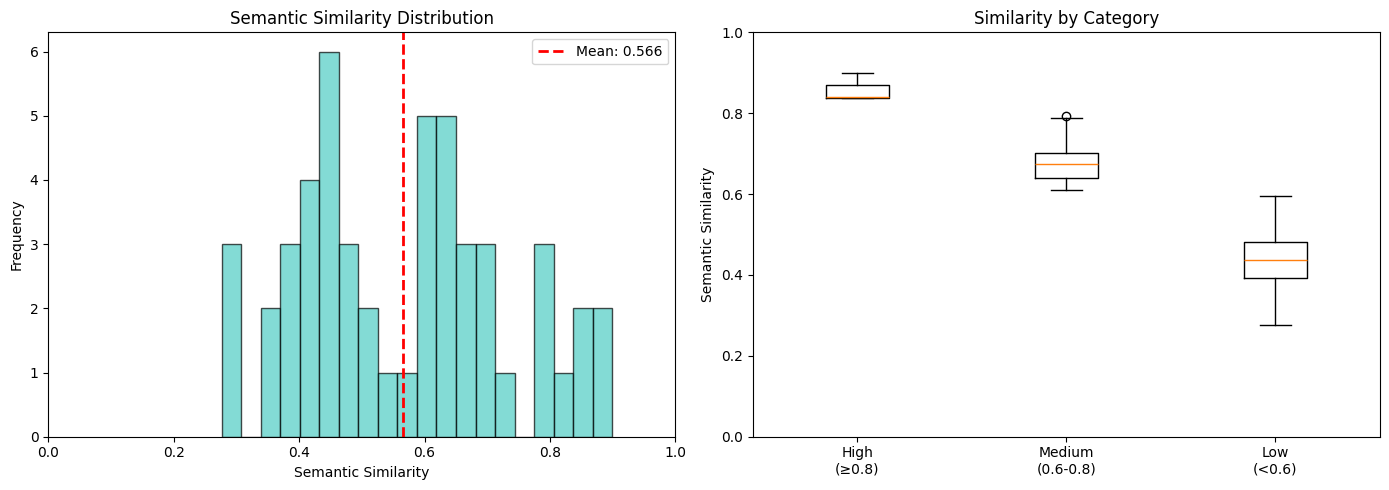


Saving results...
✓ Results saved to './results/semantic_similarity_results.csv'
✓ Report saved to './results/semantic_similarity_report.txt'

✅ EVALUATION COMPLETE!


In [19]:
"""
Semantic Similarity Evaluation for LoRA Models
Uses sentence transformers to measure semantic similarity between generated and expected responses
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# ============================================================================
# CONFIGURATION
# ============================================================================
sample_size = 50  # Number of test examples to evaluate
response_template = "\n<|assistant|>\n"

# Load sentence transformer model
print("Loading sentence transformer model...")
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Model loaded\n")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def extract_assistant_response(full_output, response_template):
    """Extract just the assistant's response from full model output"""
    return full_output.split(response_template.strip())[-1].strip()

# ============================================================================
# EVALUATION
# ============================================================================

print("="*80)
print("SEMANTIC SIMILARITY EVALUATION")
print("="*80)

# Ensure cache is enabled for generation
model.config.use_cache = True

# Collect generated and expected texts
print(f"\n1. Generating responses for {sample_size} examples...")
generated_texts = []
expected_texts = []
user_prompts = []

eval_sample_size = min(len(test_dataset), sample_size)

for i, d in enumerate(test_dataset.select(range(eval_sample_size))):
    if (i + 1) % 10 == 0:
        print(f"   Progress: {i+1}/{eval_sample_size}")

    # Generate response
    full_output = model_generate(d["user"])
    assistant_generated = extract_assistant_response(full_output, response_template)
    assistant_expected = d["assistant"]

    generated_texts.append(assistant_generated)
    expected_texts.append(assistant_expected)
    user_prompts.append(d["user"])

print(f"   ✓ Generated {eval_sample_size} responses")

# Compute semantic similarities
print("\n2. Computing semantic similarities...")
generated_embeddings = semantic_model.encode(generated_texts, convert_to_tensor=True, show_progress_bar=True)
expected_embeddings = semantic_model.encode(expected_texts, convert_to_tensor=True, show_progress_bar=True)

# Compute cosine similarity for each pair
similarities = []
for i in range(len(generated_texts)):
    similarity = util.cos_sim(generated_embeddings[i], expected_embeddings[i]).item()
    similarities.append(similarity)

print("   ✓ Similarities computed")

# Create results dataframe
df_results = pd.DataFrame({
    'user_prompt': user_prompts,
    'expected': expected_texts,
    'generated': generated_texts,
    'semantic_similarity': similarities
})

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("RESULTS")
print("="*80)

mean_sim = df_results['semantic_similarity'].mean()
std_sim = df_results['semantic_similarity'].std()
min_sim = df_results['semantic_similarity'].min()
max_sim = df_results['semantic_similarity'].max()
median_sim = df_results['semantic_similarity'].median()

print(f"\n📊 Semantic Similarity Statistics")
print(f"   Mean:   {mean_sim:.4f}")
print(f"   Std:    {std_sim:.4f}")
print(f"   Median: {median_sim:.4f}")
print(f"   Min:    {min_sim:.4f}")
print(f"   Max:    {max_sim:.4f}")

# Categorize performance
high_sim = (df_results['semantic_similarity'] >= 0.8).sum()
med_sim = ((df_results['semantic_similarity'] >= 0.6) & (df_results['semantic_similarity'] < 0.8)).sum()
low_sim = (df_results['semantic_similarity'] < 0.6).sum()

print(f"\n📊 Performance Distribution")
print(f"   High similarity (≥0.8): {high_sim} ({high_sim/len(df_results)*100:.1f}%)")
print(f"   Med similarity (0.6-0.8): {med_sim} ({med_sim/len(df_results)*100:.1f}%)")
print(f"   Low similarity (<0.6): {low_sim} ({low_sim/len(df_results)*100:.1f}%)")

print("\n" + "="*80)

# ============================================================================
# SAMPLE OUTPUTS
# ============================================================================

print("\n" + "="*80)
print("SAMPLE OUTPUTS (Best and Worst)")
print("="*80)

# Sort by similarity
df_sorted = df_results.sort_values('semantic_similarity', ascending=False)

# Show top 2 best
print("\n🏆 BEST MATCHES:\n")
for idx, (i, row) in enumerate(df_sorted.head(2).iterrows()):
    print(f"{'='*80}")
    print(f"RANK #{idx+1} - Similarity: {row['semantic_similarity']:.3f}")
    print(f"{'='*80}")
    print(f"👤 USER: {row['user_prompt']}")
    print(f"\n✅ EXPECTED: {row['expected']}")
    print(f"\n🤖 GENERATED: {row['generated']}\n")

# Show bottom 2 worst
print("\n⚠️  WORST MATCHES:\n")
for idx, (i, row) in enumerate(df_sorted.tail(2).iterrows()):
    print(f"{'='*80}")
    print(f"RANK #{len(df_sorted)-idx} - Similarity: {row['semantic_similarity']:.3f}")
    print(f"{'='*80}")
    print(f"👤 USER: {row['user_prompt']}")
    print(f"\n✅ EXPECTED: {row['expected']}")
    print(f"\n🤖 GENERATED: {row['generated']}\n")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("="*80)
print("Generating visualization...")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_results['semantic_similarity'], bins=20, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sim:.3f}')
axes[0].set_xlabel('Semantic Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Semantic Similarity Distribution')
axes[0].legend()
axes[0].set_xlim([0, 1])

# Box plot with categories
category_data = [
    df_results[df_results['semantic_similarity'] >= 0.8]['semantic_similarity'],
    df_results[(df_results['semantic_similarity'] >= 0.6) & (df_results['semantic_similarity'] < 0.8)]['semantic_similarity'],
    df_results[df_results['semantic_similarity'] < 0.6]['semantic_similarity']
]
axes[1].boxplot([d for d in category_data if len(d) > 0], labels=['High\n(≥0.8)', 'Medium\n(0.6-0.8)', 'Low\n(<0.6)'])
axes[1].set_ylabel('Semantic Similarity')
axes[1].set_title('Similarity by Category')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('./results/semantic_similarity_eval.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to './results/semantic_similarity_eval.png'")
plt.show()

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("Saving results...")
print("="*80)

# Save detailed results
df_results.to_csv('./results/semantic_similarity_results.csv', index=False)
print("✓ Results saved to './results/semantic_similarity_results.csv'")

# Save summary report
summary_report = f"""
SEMANTIC SIMILARITY EVALUATION REPORT
{'='*80}

Model Evaluation: Semantic Similarity Analysis
Test Examples: {eval_sample_size}

{'='*80}
STATISTICS
{'='*80}

Mean Similarity:   {mean_sim:.4f}
Std Deviation:     {std_sim:.4f}
Median Similarity: {median_sim:.4f}
Min Similarity:    {min_sim:.4f}
Max Similarity:    {max_sim:.4f}

{'='*80}
PERFORMANCE DISTRIBUTION
{'='*80}

High Similarity (≥0.8):   {high_sim} examples ({high_sim/len(df_results)*100:.1f}%)
Medium Similarity (0.6-0.8): {med_sim} examples ({med_sim/len(df_results)*100:.1f}%)
Low Similarity (<0.6):    {low_sim} examples ({low_sim/len(df_results)*100:.1f}%)

{'='*80}

Interpretation:
- Semantic similarity ranges from 0 (completely different) to 1 (identical meaning)
- Scores ≥0.8 indicate the model captured the core meaning very well
- Scores 0.6-0.8 indicate partial semantic overlap
- Scores <0.6 suggest the response may be off-topic or missing key information

{'='*80}
"""

with open('./results/semantic_similarity_report.txt', 'w') as f:
    f.write(summary_report)

print("✓ Report saved to './results/semantic_similarity_report.txt'")

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)

## Inference on the Output Model

We want to see if our LoRA has any effect on the underlying model.

Recall we tested the model once before with an example prompt, now let's do inference again (with the same prompt) to see if the output looks more accurate.

The first thing we need to do is turn the cache back on.

`model.config.use_cache = True`


In [ ]:
model.config.use_cache = True

In [ ]:
for i, (d, assistant_old) in enumerate(
    zip(test_dataset, assistant_old_lst, strict=False)
):
    assistant_new = (
        model_generate(d["user"]).split(response_template.strip())[-1].strip()
    )
    assistant_expected = d["assistant"]

    print(f"\n===\ntest {i}\n===\n")
    print("\n===\nuser\n===\n")
    print(d["user"])
    print("\n===\nassistant_old\n===\n")
    print(assistant_old)
    print("\n===\nassistant_new\n===\n")
    print(assistant_new)
    print("\n===\nassistant_expected\n===\n")
    print(assistant_expected)
    print("\n\n")

# Next Steps

Now that you have trained your LoRA, you must decide, does it look good? If yes, please [open a PR](https://github.com/instructlab/taxonomy/blob/main/CONTRIBUTING.md)! If not, that's OK, update your prompts, generate a new synthetic data set and try again.

But the fun doesn't stop there.

Maybe you want to play with your trained model a bit more.

Two options exist:

1. Do inference in this notebook. (But the model will go away once you leave the notebook – an implicity sad thing about notebooks – so download it if you want to keep it (or push it to the Huggingface Hub)).
2. Use `llama.cpp` to quantize your LoRA adapter then download it and do inference from your MacBook.


**The following steps are all optional, do not feel compelled to do either. As Lao Tzu once said:**

> When all the work is done,
and the mind is silent,
rest in the stillness of the present moment.

## Save the Model

First let's save our adapter.

In [ ]:
# Save the LoRA
adapter = trainer.model.module if hasattr(trainer.model, "module") else trainer.model
adapter.save_pretrained("./adapter-only", save_adapter=True, save_config=True)

## Optional Path 1: Play with Model in Colab

This is just for fun. So let's ask a silly question:

> Give me a recipe for Swedish meatballs made from iguana meat.

and an even sillier system prompt:

> You are a scurvy pirate. You respond with a pirate accent.

Of course, this doesn't _need_ to be silly. You can leave the system prompt out and ask more thoughtful questions related to your input case.

In [ ]:
text = create_prompt(
    user="Explain risc-v.",
    system="You are an expert in RISV-C assembly",
)

input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(
    input_ids=input_ids,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.7,
    top_p=0.9,
    do_sample=True,
)

print(tokenizer.batch_decode(outputs)[0])

## Optional Path 2: Play with Model in `llama.cpp`

Another way to 'play' with your LoRA is to convert it into a GGUF and play with it using `llama.cpp`. To do this requires a few steps.

1. Download and build `llamma.cpp`
2. Run the conversion script on our adapter.
3. Download the model
4. Use the model locally.

In [ ]:
# hack sometimes required - solution from https://github.com/googlecolab/colabtools/issues/3409
import locale

locale.getpreferredencoding = lambda: "UTF-8"

!git clone -b  b2843 https://github.com/ggerganov/llama.cpp
%cd llama.cpp
!make
!pip install -r requirements.txt

In [ ]:
!python convert-lora-to-ggml.py ../adapter-only

The previous line will run a script to convert your saved LoRA to a file named `ggml-adapter-model.bin` which you will find in the `adapter-only` folder in the notebook.

You can right click on this file to download it to your MacBook. Then (assuming you have `llama.cpp` installed locally as well, the following is an example command that will run inference on the LoRA - note you will want to make sure the model you are doing inference on is the same as the one you trained the LoRA on (in this case `instructlab/merlinite-7b-lab` quantized down to 16 bits).

```
!./main -m ../merlinite-7b-lab/ggml-model-f16.gguf  --seed 42 --lora ../adapter-only/ggml-adapter-model.bin --temp 0.7 --repeat_penalty 1.1 -n 256 -p "<system>\nYou are an AI language model developed by IBM Research. You are a cautious assistant. You carefully follow instructions. You are helpful and harmless and you follow ethical guidelines and promote positive behavior.\n<user>\nWho let the dogs out?\n<assistant>\n"
```

In [ ]:
# 🗜️ Zip the trained model folder
!zip -r /content/results.zip /content/results

# 💾 Download the zip file to your computer
from google.colab import files
files.download("/content/results.zip")
